# 4. Constituent Level Prediction (Churn Analysis)

Here, we perform analysis at the constituent level for the years 2016/2017. We include RFM (Recency, Frequency and Monetary Value) variables into the analysis as well as generating new variables from our existing dataset.

**Objective:** Predict donor retention rates for the upcoming year. This will allow us to observe which donors are likely to stop donating and what their characteristics are. This knowledge can then be passed on to marketing strategists to develop methods of targeting these particular individuals and work on improving retention.

**Approach:** Employ typical classification models such as: random forest, boosting and logistic regression. Also cluster individuals who are predicted to churn into different groups. 

**Deployment:** After developing the model and checking that it yields a significant accuracy we export the model for pipelining and deployment on Microsoft Azure. 

**Dashboarding:** Interactive visualizations are always helpful for showing individuals or groups the process by which you get an end-result. I will try to build a quick plotly dashboard in order to show our main process and results 

https://blog.sicara.com/bokeh-dash-best-dashboard-framework-python-shiny-alternative-c5b576375f7f 


In [1]:
import numpy as np
import pandas as pd
from pandas import Series, DataFrame
import seaborn as sns 
import matplotlib.path as mplPath
import sys
import matplotlib.pyplot as plt
%matplotlib inline 
print('\033[1m' + "Python version:\n{}\n".format(sys.version))

Python version:
3.6.6 |Anaconda, Inc.| (default, Jun 28 2018, 11:27:44) [MSC v.1900 64 bit (AMD64)]



In [2]:
import os
os.chdir('M:\\PH-RPM\\Elba\\Data\\')
data= pd.read_csv('MANIFOLD_MERGED_CLEANED.csv')

#Importing Foundation data for 2016-2017 
foundation = pd.read_excel('PBI_Data_8-10-2018.xlsx')
foundation = foundation.rename(columns={'ConcatPC': 'Postal_Code'})
#foundation = foundation.drop(['First Name','Last Name'], axis =1)

#Importing Manifold data for 2017
data.to_csv('MANIFOLD_BC_ALL.csv')

In [3]:
foundation.head(5)

,CID (AG),First Name,Last Name,Organization Name,Constituency Description,Average household income $,Postal_Code,Recency(5),Frequency(10),2016,2017,2017churn,Primary RM
0,1122472,Yaohua,Dai,NaN,Individual,679097,V7V3G1,4,2,1000.0,NaN,churn,NaN
1,1071560,Hattie,Lee,NaN,Individual,678844,V7V3G2,4,3,50.0,NaN,churn,NaN
2,619413,Richard,Weir,NaN,Individual,678844,V7V3G2,4,2,5000.0,NaN,churn,NaN
3,432990,Bruce,Geddes,NaN,Individual,678703,V7V3H3,5,3,100.0,379.0,renew,NaN
4,1137335,Joe,Ryan,NaN,Individual,678699,V7V2K8,3,1,250.0,NaN,churn,NaN


In [4]:
#Merge our Manifold Data with our foundation's donation data for 2016-17
data = pd.merge(foundation, data, on='Postal_Code')

## Cleaning + Feature Engineering
***

Let's convert the variables *'Primary RM', 'Organization Name', 'Constituency Description'* and *'2017Churn'*  to dummies that we can include in our models. These variables are defined as follows:
* `Primary RM`: Individual assigned to the constituent given the latter's strong donation potential 

* `Organization Name`: For individuals who indicate organization, the name of the organization 

* `Constituency Description`: Whether the constituent is an individual or an organization 

* `2017Churn`: Whether an individual that donated in 2016 donated in 2017 or not (churn vs renew) 


In [5]:
#Converting NaN's to zero 
data['Primary RM'] = data['Primary RM'].fillna(0)
data['Primary RM'].tail(10)

#Converting names to 1 in primary RM variable 
def to_number_RM(row):
    if row!= 0:
        return 'RM' 
    elif row == 0:
        return 'No_RM'
    
#Applying function
data['Primary RM'] = data['Primary RM'].apply(to_number_RM)

#Converting names to 1 in Organization Name variable 
def to_number_Org(row):
    if row!= 0:
        return 'Organization' 
    elif row == 0:
        return 'Constituent'

#Organization Name
data['Organization Name'] = data['Organization Name'].fillna(0)
data['Constituent_Type'] = data['Organization Name'].apply(to_number_Org)

#Now we want to convert these variables to dummies for analysis
Org = pd.get_dummies(data['Constituent_Type'])
P_RM = pd.get_dummies(data['Primary RM'])
Churn = pd.get_dummies(data['2017churn'])

#Finally, we merge these to our main dataset 
data = pd.concat([data, Org], axis=1)
data = pd.concat([data, P_RM], axis=1)
data = pd.concat([data, Churn], axis=1)

#Remember that when creating dummy variables we remove one of them to avoid the 'dummy variable trap'
data = data.drop(['Organization Name','Constituency Description','2017' ,'Constituent_Type', 'No_RM', 'renew', 'Organization',\
                 '2017churn', 'Primary RM', 'Unnamed: 0'], axis=1)

In [6]:
data.head(5)

,CID (AG),First Name,Last Name,Average household income $,Postal_Code,Recency(5),Frequency(10),2016,Population_Total,Pop_15_plus,...,Tot_Priv_HH_Age_35-44,Tot_Priv_HH_Age_45-54,Tot_Priv_HH_Age_55-64,Tot_Priv_HH_Age_65-74,Tot_Priv_HH_Age_25-34,Tot_Priv_HH_Age_u_25,Tot_Priv_HH_Age_75_o,Constituent,RM,churn
0,1122472,Yaohua,Dai,679097,V7V3G1,4,2,1000.0,36,30,...,2,5,4,1,0,0,0,1,0,1
1,1071560,Hattie,Lee,678844,V7V3G2,4,3,50.0,16,14,...,1,2,2,1,0,0,0,1,0,1
2,619413,Richard,Weir,678844,V7V3G2,4,2,5000.0,16,14,...,1,2,2,1,0,0,0,1,0,1
3,432990,Bruce,Geddes,678703,V7V3H3,5,3,100.0,35,29,...,2,5,3,1,0,0,0,1,0,0
4,1137335,Joe,Ryan,678699,V7V2K8,3,1,250.0,55,46,...,2,8,5,2,0,0,0,1,0,1


In [7]:
# A bit more cleaning 
#First, we want to convert the nulls (postal codes that didn't donate in 2016/2017) to zeros
data['2016'].isnull().sum()
data['2016'] = data['2016'].fillna(0)

In [8]:
data['ChildPopRatio'] = (( data['Population_Total'] - data['Pop_15_plus'])/data['Population_Total'])

In [9]:
Household_Income = ['HH_Inc_1','HH_Inc_2','HH_Inc_3','HH_Inc_4', 'HH_Inc_5','HH_Inc_6','HH_Inc_7','HH_Inc_8',\
                   'HH_Inc_9','HH_Inc_10','HH_Inc_11','HH_Inc_12','HH_Inc_13']
d = data['Dwellings_Tot'] 

for x in Household_Income: 
    data[x] = data[x]/d

In [10]:
data['HH_Inc_Low'] =  data['HH_Inc_1'] + data['HH_Inc_2'] + data['HH_Inc_3'] + data['HH_Inc_4'] \
+ data['HH_Inc_5']  + data['HH_Inc_6'] 
data['HH_Inc_Med'] =  data['HH_Inc_7'] + data['HH_Inc_8'] + data['HH_Inc_9'] + data['HH_Inc_10'] 
data['HH_Inc_High'] = data['HH_Inc_11'] + data['HH_Inc_12'] + data['HH_Inc_13']

In [11]:
#Household ownership 
data['Owned_Dwelling_Percent'] = data['Owned-Count-PC']/data['Dwellings_Tot']
data['Rented_Dwelling_Percent'] = data['Rented-Count-PC']/data['Dwellings_Tot']
data['Band_Dwelling_Percent'] = data['Band housing-Count-PC_y']/data['Dwellings_Tot']
#Age of owners
data['Older_HH_Owners_Percent'] = (data['Tot_Priv_HH_Age_55-64'] + data['Tot_Priv_HH_Age_65-74'] + \
                                   data['Tot_Priv_HH_Age_75_o'])/data['Dwellings_Tot']
data['Younger_HH_Owners_Percent'] = (data['Tot_Priv_HH_Age_25-34'] + data['Tot_Priv_HH_Age_35-44'] + \
                                     data['Tot_Priv_HH_Age_u_25'] + data['Tot_Priv_HH_Age_45-54']  )/data['Dwellings_Tot']
data['Most_Senior_Owner_Percent'] = data['Tot_Priv_HH_Age_75_o']/data['Dwellings_Tot']

## EDA
***

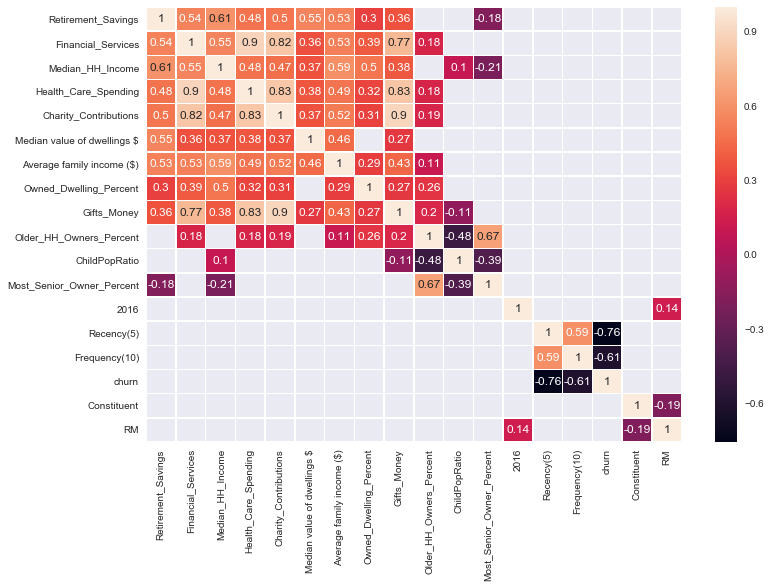

In [12]:
#Looking at correlation between variables
data_1 =data[["Retirement_Savings" ,"Financial_Services", "Median_HH_Income","Health_Care_Spending",\
             "Charity_Contributions",'Median value of dwellings $', 'Average family income ($)', 'Owned_Dwelling_Percent',\
            'Gifts_Money', 'Older_HH_Owners_Percent',"ChildPopRatio",'Most_Senior_Owner_Percent', '2016',\
             'Recency(5)','Frequency(10)', 'churn', 'Constituent', 'RM', 'First Name']] 

corr = data_1.corr()
sns.set(font_scale = 1.0)
mask = np.absolute(corr) > 0.10
fig, ax = plt.subplots(figsize=(12,8)) # Sample figsize in inches

g = sns.heatmap(corr[mask], 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values,annot=True,  linewidths=.5,ax=ax)
plt.show()

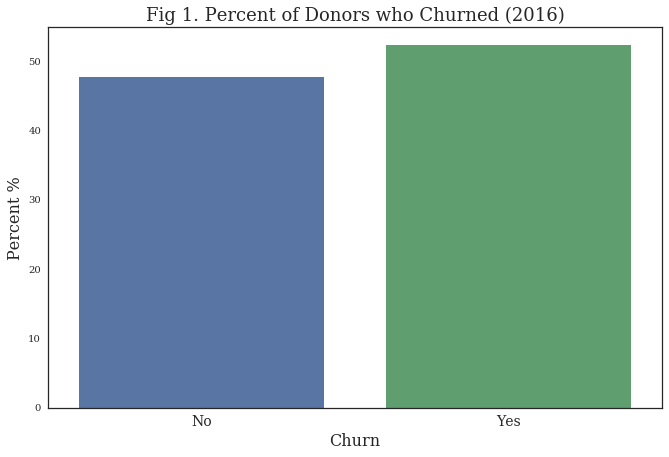

In [13]:
#Plot donor churn 
sns.set_style('whitegrid')
sns.set_style("white", {
        "font.family": "serif",
        "font.serif": ["Times", "Palatino", "serif"]
    })

plt.figure(figsize=(11,7))

#sns.set_style('whitegrid')
#sns.set(font_scale = 1.4)

plot = sns.barplot(x='churn', y='churn' , data=data, estimator=lambda churn: len(churn) / len(data) * 100)
plot.set_xlabel(xlabel='Churn', fontsize=16)
plot.set_xticklabels(('No', 'Yes'), fontsize=14)
plot.set_ylabel(ylabel='Percent %', fontsize=16)
plot.set_title(label='Fig 1. Percent of Donors who Churned (2016)', fontsize=18)

plt.show();
fig = plot.get_figure()
fig.savefig('C:\\Users\\egomez\\Desktop\\Jupyter_Notebooks\\churn.png')

* Here we can observe that 53% of donors that donated in 2016 didn't donate in 2017 while 47% of individuals that donated in 2016 continued to donate the following year.

<Figure size 432x288 with 0 Axes>

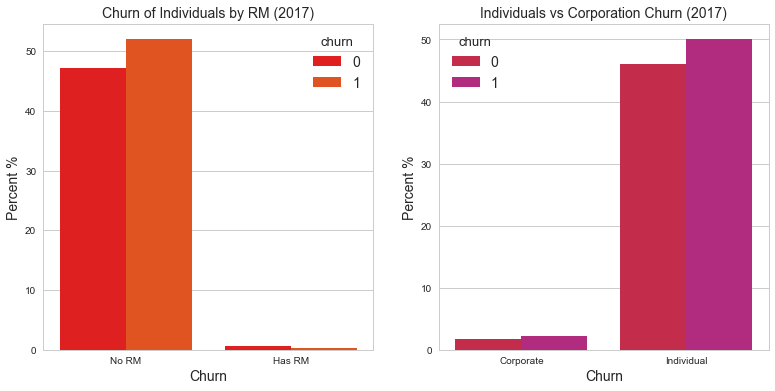

In [14]:
#Now we want to take a look at the variables we just created: 'churn', 'Constituent', 'RM'
#Plot donor churn 
plt.figure(figsize=(6,4))
sns.set_style('whitegrid')

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 6))


sns.set(font_scale = 1.4)

fig1 = sns.barplot(x='RM', y='RM' , data=data, estimator=lambda RM: len(RM) / len(data) * 100, hue='churn',\
               palette = ['r', 'orangered'], ax=ax1)

fig1.set_xlabel(xlabel='Churn', fontsize=14)
fig1.set_xticklabels(('No RM', 'Has RM'))
fig1.set_ylabel(ylabel='Percent %', fontsize=14)
fig1.set_title(label='Churn of Individuals by RM (2017)', fontsize=14)

fig2 = sns.barplot(x='Constituent', y='Constituent' , data=data, estimator=lambda Constituent: len(Constituent) / len(data) * 100, hue='churn',\
                palette=['crimson', 'mediumvioletred'], ax=ax2)
fig2.set_xlabel(xlabel='Churn', fontsize=14)
fig2.set_xticklabels(('Corporate', 'Individual'))
fig2.set_ylabel(ylabel='Percent %', fontsize=14)
fig2.set_title(label='Individuals vs Corporation Churn (2017)', fontsize=14)
plt.show();


fig = fig2.get_figure()
fig.savefig('C:\\Users\\egomez\\Desktop\\Jupyter_Notebooks\\RM_Const.png')

* Looking at our new features, we observe that for individuals with or without RM the probability of churning is mostly in tandem with the overall 53-47% probabilities. Interestingly, for individuals who do have an RM, more of them tend to renew rather than churn. In terms fo individuals vs. corporations, we see almost the same trend as overall for either alternative. 

* Thus, these new features don't bring too much variation in terms of discerning who churns vs who doesn't. Yet, for now, since we don't have too many variables, we keep this additional information. 

<Figure size 432x288 with 0 Axes>

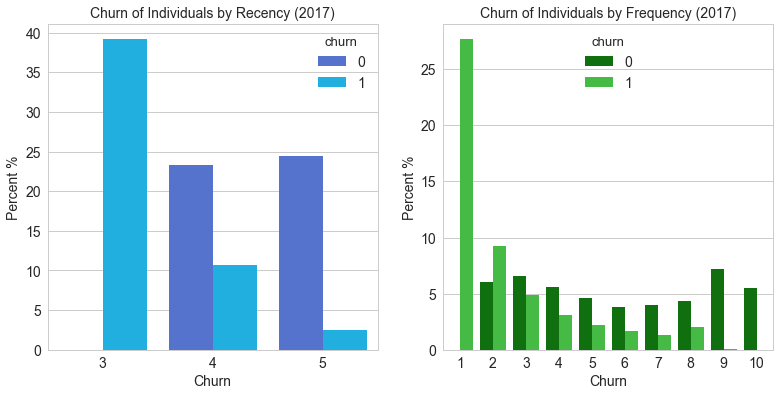

In [15]:
#Now we want to take a look at the variables we just created: 'churn', 'Constituent', 'RM'
#https://python-graph-gallery.com/100-calling-a-color-with-seaborn/
data = data.rename(columns={'Recency(5)': 'Recency_5', 'Frequency(10)': 'Frequency_10'})
sns.set_style('whitegrid')

#Plot donor churn 
plt.figure(figsize=(6,4))

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 6))


sns.set(font_scale = 1.4)

fig1 = sns.barplot(x='Recency_5', y='Recency_5' , data=data, estimator=lambda Recency_5: len(Recency_5) / len(data) * 100, hue='churn',\
                palette=['royalblue', 'deepskyblue'], ax=ax1)

fig1.set_xlabel(xlabel='Churn', fontsize=14)
fig1.set_ylabel(ylabel='Percent %', fontsize=14)
fig1.set_title(label='Churn of Individuals by Recency (2017)', fontsize=14)
sns.set_style("whitegrid")

fig2 = sns.barplot(x='Frequency_10', y='Frequency_10' , data=data, estimator=lambda Frequency_10: len(Frequency_10) / len(data) * 100, hue='churn',\
                palette=['green', 'limegreen'], ax=ax2)
fig2.set_xlabel(xlabel='Churn', fontsize=14)
fig2.set_ylabel(ylabel='Percent %', fontsize=14)
fig2.set_title(label='Churn of Individuals by Frequency (2017)', fontsize=14)
plt.show();

fig = fig2.get_figure()
fig.savefig('C:\\Users\\egomez\\Desktop\\Jupyter_Notebooks\\Rec_Freq.png')

First, let's define the RFM variables: 
* `Recency`: How recently a customer has purchased; in our case how recently a constituent has donated where our scale goes from 1: last time they donated was 5 years ago to 5: they donated last year (excluding the fact that they donated in 2016)
* `Frequency`: How often they donate: 10 means they have donated 10 times in the past 10 years whereas 1 means that they have donated once in the past 10 years 
* `Monetary Value`: How much the customer spends. This would be our 2016 variable

**Observations:** note that individuals that donated in 2016 have made previous donations as old as three years ago max but not further (eg. no one that doanted in 2016 donated last in 2012). In terms of frequency, constituents that have donated more than two times in the past 10 years have a higher retention to churn rates. 

We also want to understand what type of donors are churning at the highest rates. For example, is it donors that are new to donating? Is it donors that donated very infrequently in the past? We'll take a look based on our three RFM variables. 

<Figure size 720x432 with 0 Axes>

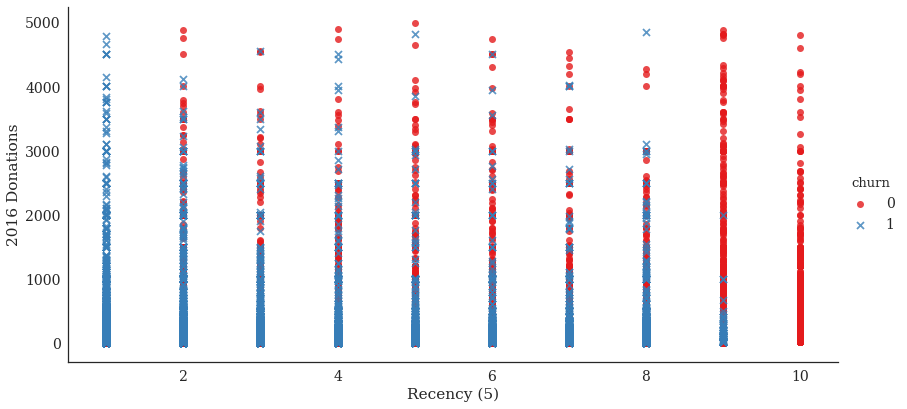

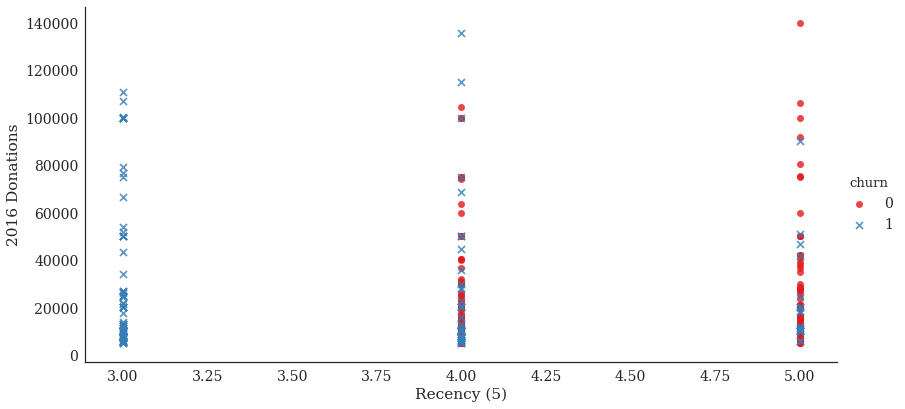

In [16]:
# We want to keep only the individuals that have donated less than 5000
middle = data['2016'] < 5000
data_1 = data[middle]
#data_1 = data_1[['Recency_5','Frequency_10', '2016']]

#High 
high = data['2016'] > 5000
data_2 = data[high]
minus = data_2['2016'] <150000
data_3 = data_2[minus]
#Plot donor churn 
plt.figure(figsize=(10,6));

sns.set_style("white", {
        "font.family": "serif",
        "font.serif": ["Times", "Palatino", "serif"]
    })

# Use the 'hue' argument to provide a factor variable
ax_1 = sns.lmplot( x="Frequency_10", y="2016", data=data_1, fit_reg=False, hue='churn', legend=True, palette="Set1", markers=["o", "x"],size=6, aspect=2) 
ax_1.set(xlabel='Recency (5)', ylabel='2016 Donations')

# Use the 'hue' argument to provide a factor variable
ax_2 = sns.lmplot( x="Recency_5", y="2016", data=data_3, fit_reg=False, hue='churn', legend=True, palette="Set1", markers=["o", "x"],size=6, aspect=2) 
ax_2.set(xlabel='Recency (5)', ylabel='2016 Donations')

plt.show()

<Figure size 720x432 with 0 Axes>

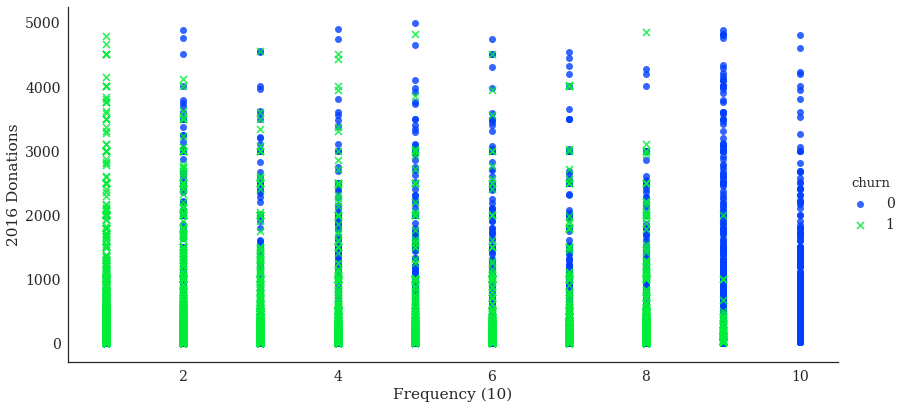

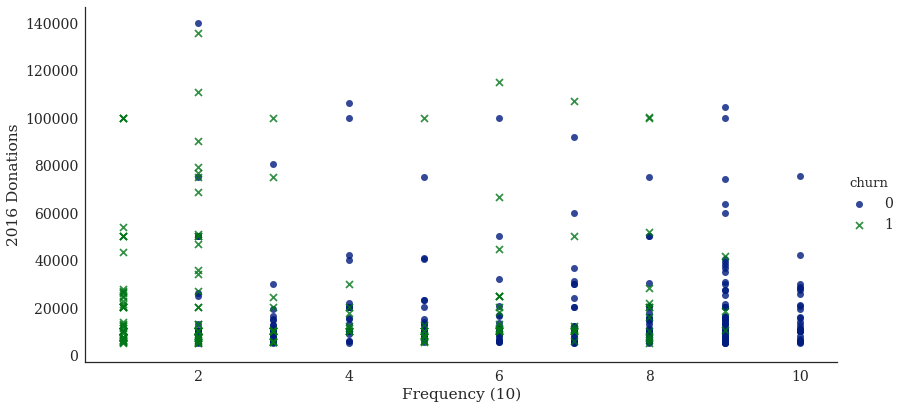

In [17]:
# We want to keep only the individuals who churned  
middle = data['2016'] < 5000
data_1 = data[middle]
#data_1 = data_1[['Recency_5','Frequency_10', '2016']]

#High 
high = data['2016'] > 5000
data_2 = data[high]
minus = data_2['2016'] <150000
data_3 = data_2[minus]
#Plot donor churn 
plt.figure(figsize=(10,6));

# Use the 'hue' argument to provide a factor variable
ax_3 = sns.lmplot( x="Frequency_10", y="2016", data=data_1, fit_reg=False, hue='churn', legend=True, palette="bright", markers=["o", "x"],size=6, aspect=2) 
ax_3.set(xlabel='Frequency (10)', ylabel='2016 Donations')

sns.set_style("white", {
        "font.family": "serif",
        "font.serif": ["Times", "Palatino", "serif"]
    })

# Use the 'hue' argument to provide a factor variable
ax_4 = sns.lmplot( x="Frequency_10", y="2016", data=data_3, fit_reg=False, hue='churn', legend=True, palette="dark", markers=["o", "x"],size=6, aspect=2) 
ax_4.set(xlabel='Frequency (10)', ylabel='2016 Donations')

**Observations**: 
   * **Donations vs Recency** From the plot above we can observe the following:
* **Donations (0-5,000)** As we can observe, most individuals that have a recency score of 3 (meaning that besides 2016, the last time they donated was 2013) will churn out next year (2017) at all levels of donation. The trend is less clear for individuals that donated in either 2015 and/or 2014. We can observe that for those with a recency of 4- individuals that donated from 1000-2,500 will churn out while those that donated more than that will renew in 2017. For the recency score of 5, the upper bound for individuals who churn is 1500.
* **Donations (5,000-150,000)** Similar patterns are observed for these donation ranges but we can also observe that the inidividuals who churn are significantly less prominent for scores of 4 and 5. 

   * **Donations vs Frequency**: From the plot above we can observe the following:
* **Donations (0-5,000):** we see a consistent decline in renewals for 2017 with individuals that have donated less frequently in the past. Interestingly, this decline is most evident for individuals that have additionally made a relatively small contribution (less than 1,000 in donation) 
* **Donations (5,000-150,000):** We observe a less clear pattern with the only clear trends being the extremes. 

## Grouping Lapsed Donors

To perform RFM analysis, we divide customers into five equal groups according to the distribution of values for recency, frequency, and monetary value.

| Recency  | Frequency | Monetary Value |
|----------|:-------------:|:-------------:|
|Quintile 1 (R=1)   |Quintile 1 (F=1)  |Quintile 1 (M=1) |
|Quintile 2 (R=2)   |Quintile 2 (F=2)  |Quintile 2 (M=2) |
|Quintile 3 (R=3)   |Quintile 3 (F=3)  |Quintile 3 (M=3) |
|Quintile 4 (R=4)   |Quintile 4 (F=4)  |Quintile 4 (M=4) |
|Quintile 5 (R=5)   |Quintile 5 (F=5)  |Quintile 5 (M=5) |

Now, we can take a look at some of our donors' scores:

| Name  | RFM | Potential Group|
|----------|:-------------:|:-------------:|
| Yaohua |415 |Loyal Customers |
| Hattie |423 |Loyal Customers |
| Richard |415 |Big Spender |

Note that at this point, we have 5x3x5 = 75 different scores for our donors. For these types of problems, market analysts then construct different conceptual groups along the lines of the table below: 



* Link:https://joaocorreia.io/blog/rfm-analysis-increase-sales-by-segmenting-your-customers.html 

In [18]:
#Quantile-based discretization function. Discretize variable into equal-sized buckets based on rank or based on sample quantiles
#Categories (5, interval[float64]): [(0.349, 20.0] < (20.0, 35.0] < (35.0, 80.0] < (80.0, 188.0] < (188.0, 2850000.0]]
data['M'] = pd.qcut(x=data['2016'], q=5,labels=[1,2,3,4,5])

#Now, we split our Frequency quintiles information. Since it's on a 1-10 scale we can split these as 1,2 < 3,4 < 5,6 < 7,8 < 9,10 
def Create_quint(row):
    if row == 1 or row == 2:
        return '1' 
    if row == 3 or row == 4:
        return '2' 
    if row == 5 or row == 6:
        return '3' 
    if row == 7 or row == 8:
        return '4' 
    if row == 9 or row == 10:
        return '5' 
    
data['F'] = data['Frequency_10'].apply(Create_quint)

data = data.rename(index=str, columns={"Recency_5": "R"})

#Now, we have the following scoring system
#data[['First Name','R', 'F', 'M']].head(5)

data['RFM'] = data['R'].astype(str) + data['F'].astype(str) + data['M'].astype(str)

#data[['First Name', 'RFM']].head(5)

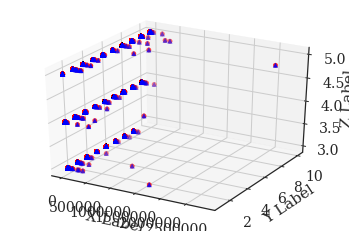

In [20]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np

def randrange(n, vmin, vmax):
    '''
    Helper function to make an array of random numbers having shape (n, )
    with each number distributed Uniform(vmin, vmax).
    '''
    return (vmax - vmin)*np.random.rand(n) + vmin

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

n = 100

# For each set of style and range settings, plot n random points in the box
# defined by x in [23, 32], y in [0, 100], z in [zlow, zhigh].
for c, m, zlow, zhigh in [('r', 'o', -50, -25), ('b', '^', -30, -5)]:
    xs = randrange(n, 23, 32)
    ys = randrange(n, 0, 100)
    zs = randrange(n, zlow, zhigh)
    ax.scatter(data['2016'], data['Frequency_10'], data['R'], c=c, marker=m)

ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

plt.show()

In [38]:
import plotly
import plotly.offline as offline
import plotly.graph_objs as go
import pandas as pd
#https://stackoverflow.com/questions/41323423/plotly-inside-jupyter-notebook-python (using plotly offline)
from plotly.offline import init_notebook_mode, iplot
from plotly.graph_objs import *
df = pd.read_csv('https://raw.githubusercontent.com/plotly/datasets/master/iris.csv')
df.head()

plotly.offline.init_notebook_mode(connected=True)

data = []
clusters = []
colors = ['rgb(228,26,28)','rgb(55,126,184)','rgb(77,175,74)']

for i in range(len(df['Name'].unique())):
    name = df['Name'].unique()[i]
    color = colors[i]
    x = df[ df['Name'] == name ]['SepalLength']
    y = df[ df['Name'] == name ]['SepalWidth']
    z = df[ df['Name'] == name ]['PetalLength']
    
    trace = dict(
        name = name,
        x = x, y = y, z = z,
        type = "scatter3d",    
        mode = 'markers',
        marker = dict( size=3, color=color, line=dict(width=0) ) )
    data.append( trace )

    layout = dict(
    width=800,
    height=550,
    autosize=False,
    title='Iris dataset',
    scene=dict(
        xaxis=dict(
            gridcolor='rgb(255, 255, 255)',
            zerolinecolor='rgb(255, 255, 255)',
            showbackground=True,
            backgroundcolor='rgb(230, 230,230)'
        ),
        yaxis=dict(
            gridcolor='rgb(255, 255, 255)',
            zerolinecolor='rgb(255, 255, 255)',
            showbackground=True,
            backgroundcolor='rgb(230, 230,230)'
        ),
        zaxis=dict(
            gridcolor='rgb(255, 255, 255)',
            zerolinecolor='rgb(255, 255, 255)',
            showbackground=True,
            backgroundcolor='rgb(230, 230,230)'
        ),
        aspectratio = dict( x=1, y=1, z=0.7 ),
        aspectmode = 'manual'        
    ),
)

fig = dict(data=data, layout=layout)

iplot(data)

In [39]:
import plotly
import plotly.offline as offline
import plotly.graph_objs as go
import pandas as pd
#https://stackoverflow.com/questions/41323423/plotly-inside-jupyter-notebook-python (using plotly offline)
from plotly.offline import init_notebook_mode, iplot
from plotly.graph_objs import *
df = pd.read_csv('https://raw.githubusercontent.com/plotly/datasets/master/iris.csv')
df.head()

plotly.offline.init_notebook_mode(connected=True)

x, y, z = np.random.multivariate_normal(np.array([0,0,0]), np.eye(3), 200).transpose()
trace1 = go.Scatter3d(
    x=x,
    y=y,
    z=z,
    mode='markers',
    marker=dict(
        size=12,
        line=dict(
            color='rgba(217, 217, 217, 0.14)',
            width=0.5
        ),
        opacity=0.8
    )
)

x2, y2, z2 = np.random.multivariate_normal(np.array([0,0,0]), np.eye(3), 200).transpose()
trace2 = go.Scatter3d(
    x=x2,
    y=y2,
    z=z2,
    mode='markers',
    marker=dict(
        color='rgb(127, 127, 127)',
        size=12,
        symbol='circle',
        line=dict(
            color='rgb(204, 204, 204)',
            width=1
        ),
        opacity=0.9
    )
)
data = [trace1, trace2]
layout = go.Layout(
    margin=dict(
        l=0,
        r=0,
        b=0,
        t=0
    )
)
fig = go.Figure(data=data, layout=layout)

iplot(data)

## Prediction
***
Now we move on to the prediction section. We will use three commonly used classfication models: Boosting Decision Trees, Random Forest and Logistic Regression: 

* `Boosting`
* `Random Forest` 
* `Logistic Regression`

## `Logistic Regression`

In [ ]:
rng = np.random.RandomState(1)
rng

In [ ]:
#Remove last year 
def Remove_last_year_1(row):
    if row == 10:
        return '9' 
    if row == 9: 
        return '9'
    if row == 8:
        return '8'
    if row ==7:
        return '7'
    if row ==6:
        return '6'
    if row ==5:
        return '5'
    if row ==4:
        return '4'
    if row ==3:
        return '3'
    if row ==2:
        return '2'
    if row ==1:
        return '1'
def Remove_last_year_2(row):
    if row == 5:
        return '4' 
    if row ==4:
        return '4'
    if row ==3:
        return '3'
    if row ==2:
        return '2'
    if row ==1:
        return '1'   
data['Recency(4)'] = data['Recency_5'].apply(Remove_last_year_2)
data['Frequency(9)'] = data['Frequency_10'].apply(Remove_last_year_1)

## `Boosting Decision Trees`

`Boosting`: Basically, boosting algorithms iteratively learn on weak classifiers and add them up to construct a strong classifier. In order to do this, for each iteration the algorithm re-weights the misclassified observartions such that the model needs to pay more attention to them on the next iteration. In this case, we use boosting to reduce the exessive variance present in decision trees. 

In [ ]:
#Import modules 
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
#Import these for pickling and exporting model 
import pickle
import sys
import os

# create the outputs folder
os.makedirs('./Output_Models', exist_ok=True)

# Instantiate a DecisionTreeClassifier 'dt' with a maximum depth of 6
dt = DecisionTreeClassifier(max_depth=6, random_state=1, criterion='entropy')

# Instantiate ada
ada = AdaBoostClassifier(base_estimator=dt, n_estimators=180 , random_state=1)

#Separate features and outcome
X = data[["Retirement_Savings" ,"Financial_Services", "Median_HH_Income","Health_Care_Spending",\
             "Charity_Contributions",'Median value of dwellings $', 'Average family income ($)', 'Owned_Dwelling_Percent',\
            'Gifts_Money', 'Older_HH_Owners_Percent',"ChildPopRatio",'Most_Senior_Owner_Percent',\
            'Constituent', 'RM', 'Recency(4)','Frequency(9)', '2016']]
y = data['churn']

# Split the data into 70% train and 30% test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=rng)

# Fit ada to the training set
ada.fit(X_train, y_train)

# Compute the probabilities of obtaining the positive class
y_pred_proba = ada.predict_proba(X_test)[:,1]

# Import roc_auc_score
from sklearn.metrics import roc_auc_score

# Evaluate test-set roc_auc_score
ada_roc_auc = roc_auc_score(y_test, y_pred_proba)

# Print roc_auc_score
print('ROC AUC score: {:.2f}'.format(ada_roc_auc))

# serialize the model on disk in the special 'outputs' folder
print ("Export the model to model.pkl")
f = open('./Output_Models/model_boosting.pkl', 'wb')
pickle.dump(y_pred_proba, f)
f.close()

## `Random Forest`

* Here we run a RF model with around 500 trees
* We also export our model using both: `pickle` and `joblib`

In [ ]:
# PREPROCESSING
# Load scikit's random forest classifier library
from sklearn.ensemble import RandomForestClassifier

#Import these for pickling and exporting model 
import pickle
import sys
import os

#Separate features and outcome
X = data[["Retirement_Savings" ,"Financial_Services", "Median_HH_Income","Health_Care_Spending",\
             "Charity_Contributions",'Median value of dwellings $', 'Average family income ($)', 'Owned_Dwelling_Percent',\
            'Gifts_Money', 'Older_HH_Owners_Percent',"ChildPopRatio",'Most_Senior_Owner_Percent',\
            'Constituent', 'RM', 'Recency(4)','Frequency(9)', '2016']]
y = data['churn']

# Split the data into 70% train and 30% test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=rng)

# Create a random forest Classifier. By convention, clf means 'Classifier'
rf = RandomForestClassifier(n_estimators=500, random_state=0)

# Train the Classifier to take the training features and learn how they relate
# to the training y (the species)
rf_model = rf.fit(X_train, y_train)
print(rf_model)

y_pred_proba = rf.predict(X_test)

# Import roc_auc_score
from sklearn.metrics import roc_auc_score

# Evaluate test-set roc_auc_score
roc_auc = roc_auc_score(y_test, y_pred_proba)

# Print roc_auc_score
print('ROC AUC score: {:.2f}'.format(roc_auc))

# serialize the model on disk in the special 'outputs' folder
print ("Export the model to model.pkl")
f = open('./Output_Models/model.pkl', 'wb')
pickle.dump(rf_model, f)
f.close()

#export the model using the pickle alternative 'joblib'
from sklearn.externals import joblib
 
#Export variable my_ml_model to file ExportedFileName.p
joblib.dump(rf_model, 'M:\PH-RPM\Elba\Data\Output_Models\model_2.p')

### Now, we want to visualize feature importance 

In [ ]:
rf.feature_importances_

In [ ]:
import pandas as pd
feature_imp = pd.Series(rf.feature_importances_, index =['Retirement_Savings' ,'Financial_Services', 'Median_HH_Income', \
                                                         "Health_Care_Spending","Charity_Contributions",'Median value of dwellings $', \
                                                         'Average family income ($)', 'Owned_Dwelling_Percent','Gifts_Money', \
                                                         'Older_HH_Owners_Percent',"ChildPopRatio",'Most_Senior_Owner_Percent',\
                                                         'Constituent', 'RM', 'Recency(4)','Frequency(9)', '2016'] ).sort_values(ascending=False)
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
#Creating a bar plot
plt.figure(figsize=(11,7))
sns.barplot(x=feature_imp, y=feature_imp.index)
# Add labels to your graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Feature Importance")
plt.legend(['Remove','Remove'])
plt.show()
fig.savefig('feature_imp.png')

* As we expected, our new variables- namely *'Constituent'* and *'RM'* are not very important in terms of predicting rentention rates for a particular year. Therefore, we will now eliminate them and re-run our model.

In [ ]:
# PREPROCESSING
# Load scikit's random forest classifier library
from sklearn.ensemble import RandomForestClassifier

#Separate features and outcome
#X = data[["Retirement_Savings" ,"Financial_Services", "Median_HH_Income","Health_Care_Spending",\
#             "Charity_Contributions",'Median value of dwellings $', 'Average family income ($)', 'Owned_Dwelling_Percent',\
#            'Gifts_Money', 'Older_HH_Owners_Percent',"ChildPopRatio",'Most_Senior_Owner_Percent',\
#              'Recency(4)','Frequency(9)']]
y = data['churn']

# Split the data into 70% train and 30% test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=rng)

# Create a random forest Classifier. By convention, clf means 'Classifier'
rf = RandomForestClassifier(n_estimators=500, random_state=0)

# Train the Classifier to take the training features and learn how they relate
# to the training y (the species)
rf.fit(X_train, y_train)

y_pred_proba = rf.predict(X_test)

# Import roc_auc_score
from sklearn.metrics import roc_auc_score

# Evaluate test-set roc_auc_score
roc_auc = roc_auc_score(y_test, y_pred_proba)

# Print roc_auc_score
print('ROC AUC score: {:.2f}'.format(roc_auc))

### `Comparing Accuracy of our models`


In [ ]:
# Converting the ROC AUC scores from our models to a dataframe 
x = [roc_auc,ada_roc_auc ]
m = ['Random Forest', 'Boosting DT']
scores = {'ROC':x, 'Mod_Name': m}
scores = pd.DataFrame(data=scores)
scores.head()

#Plot donor churn 
plt.figure(figsize=(8,6))


fig1 = sns.barplot(x='Mod_Name', y='ROC', data=scores, palette=['royalblue', 'deepskyblue'])

fig1.set_xlabel(xlabel='Models', fontsize=14)
fig1.set_ylabel(ylabel='Percent %', fontsize=14)
fig1.set_title(label='Accuracy Scores by Model', fontsize=14)

plt.show()

As we can observe, the most accurate model is our Boosted Decision Tree, with $95\%$ accuracy. Note that here we limit ourselves to this performance metric since our sample is extremely balanced (almost 50-50 split) so we don't need more nuance. 

### Creating Dummy 2018 Data 
For the purposes of checking our model exported to Azure, we just substring our dataset and slightly edit it to mimic 2018 data. We just want to make sure our model works properly etc. 

In [ ]:
X = data[["Retirement_Savings" ,"Financial_Services", "Median_HH_Income","Health_Care_Spending",\
             "Charity_Contributions",'Median value of dwellings $', 'Average family income ($)', 'Owned_Dwelling_Percent',\
            'Gifts_Money', 'Older_HH_Owners_Percent',"ChildPopRatio",'Most_Senior_Owner_Percent',\
            'Constituent', 'RM', 'Recency(4)','Frequency(9)', '2016']]

X = X[0:10]

X.to_csv('M:\PH-RPM\\Elba\\Data\\DUMMY_2018.csv')

X.head()
X.info()

In [ ]:
X.info()

Then I make some fun manual changes to the data to make it slightly different from the data we used to train the model (I edit manually in excel- and re import it) 

In [ ]:
Dummy_2018= pd.read_csv('C:\\Users\\egomez\\Desktop\\DUMMY_2018_2.csv')
Dummy_2018 = Dummy_2018.drop(['Unnamed: 0'], axis=1)
Dummy_2018.head()
#list(Dummy_2018)

In [ ]:
rf.predict(Dummy_2018)

* https://joaocorreia.io/blog/rfm-analysis-increase-sales-by-segmenting-your-customers.html
* https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4827627/

### Segmenting based on RFM

Here, we want to split our data into 'segments' based on their RFM scores. We want to indetify, amongst the individuals who have lapsed, who we should focus on in terms of retention efforts. 

## Conclusion